# Model Exploration - Binary (ML50-2023)

## __Importing libraries__

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint


# Data imports
test = pd.read_csv('Data/test_cleaned.csv', index_col=0)
train = pd.read_csv('Data/train_cleaned.csv', index_col=0)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## __Small processing__

In [203]:
train = train.reset_index(drop=True).drop(columns=['c_patient'])
b_target = train['b_target']
c_target = train['c_target']
train = train.drop(columns=['b_target', 'c_target'])
test = test.drop(columns=['c_patient'])

In [204]:
cols_payer = [col for col in train.columns if col.startswith('b_payer_')]
cols_drop = ['b_admission_Elective', 'b_admission_Urgent',
                                               'b_race_Asian', 'b_race_Hispanic', 'b_race_Other',
                                               'b_source_Referral', 'b_source_Transfer', 'b_source_Unknown'] + cols_payer
train_light = train.drop(columns=cols_drop)
test_light = test.drop(columns=cols_drop)

cols_payer_group = [col for col in train.columns if col.startswith('b_payer_group_')]
train_heavy = train.drop(columns=cols_payer_group)
test_heavy = test.drop(columns=cols_payer_group)

## __Model Testing__

### __Feature Selection__

### __Functions__

In [13]:
def get_train_val(X_, y_, test_size=0.3, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, verbose=False, return_scaler=False):    
    X = X_.copy()
    y = y_.copy()
    numeric_cols = [col for col in X.columns if col.startswith('n_')]
    if scaler:
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
        
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    if sampler == 'simple': 
        print(f'Simple sampling with minority factor {minority_factor}') if verbose else None
        X_res = pd.concat([X_train, y_train], axis=1)
        minority_class = X_res[X_res[y.name] == 1]
        majority_class = X_res[X_res[y.name] == 0]
        # Using the resample function to upsample the minority class
        minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)

        upsampled = pd.concat([majority_class, minority_upsampled])
        X_train = upsampled.drop(columns=y.name)
        y_train = upsampled[y.name]
    # Using SMOTE to upsample the minority class, or other IMBLEARN samplers
    elif sampler:
        print('Using {} sampler'.format(sampler)) if verbose else None
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    if return_scaler:
        return X_train, X_val, y_train, y_val, scaler
    else:
        return X_train, X_val, y_train, y_val 

In [14]:
def test_model(model, X_, y_, just_score=False, scaler=MinMaxScaler(), test_size=0.3, sampler='simple', minority_factor=1, verbose=False, return_scaler=False, return_X=False): 
    X = X_.copy()
    y = y_.copy()
    
    if return_scaler:
        X_train, X_test, y_train, y_test, scaler = get_train_val(X_=X, y_=y, test_size=test_size, scaler=scaler, sampler=sampler, minority_factor=minority_factor, verbose=verbose, return_scaler=return_scaler)
    else:
        X_train, X_test, y_train, y_test = get_train_val(X_=X, y_=y, test_size=test_size, scaler=scaler, sampler=sampler, minority_factor=minority_factor, verbose=verbose, return_scaler=return_scaler)
    
    fit = model.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    if just_score:
        return fit, f1_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    if return_scaler and return_X:
        return fit, scaler, X_test, y_test
    elif return_scaler:
        return fit, scaler
    elif return_X:
        return fit, X_test, y_test
    else :
        return fit

In [15]:
def perform_random_search(X, y, model, params_dict, sampler=RandomOverSampler(), scaler=MinMaxScaler(), target='b_target'):
   # Create a pipeline
   pipeline = ImbPipeline([
       ('sampler', sampler),
       ('scaler', scaler),
       ('model', model)
   ])

   # Perform randomized search
   random_search = RandomizedSearchCV(pipeline, params_dict, cv=5, n_jobs=1, random_state=42, verbose=1, scoring='f1')
   random_search.fit(X, y)

   # Print the best parameters
   print("Best parameters: ", random_search.best_params_)

   # Return the best estimator
   return random_search.best_estimator_

In [132]:
def test_model_cv(X_, y_, model, scaler, params=None, sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True, score_greedy=None, n_jobs=-1):
    X = X_.copy()
    y = y_.copy()
    # Lets program the cv manually so that we can track the progress
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    print(params) if (verbose and params) else None
    if params and n_jobs:
        model = model(**params, random_state=42, n_jobs=n_jobs)
    elif params:
        model = model(**params, random_state=42)
    scores_test, scores_train = [], []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(f'Starting fold {i+1}/{cv}...') if verbose else None
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

        # Scale the data
        numeric_cols = [col for col in X_train.columns if col.startswith('n_')]
        X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

        # Resample the data
        if sampler == 'simple':
            X_res = pd.concat([X_train, y_train], axis=1)
            minority_class = X_res[X_res[y.name] == 1]
            majority_class = X_res[X_res[y.name] == 0]
            # Using the resample function to upsample the minority class
            minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)
            upsampled = pd.concat([majority_class, minority_upsampled])
            X_train = upsampled.drop(columns=y.name)
            y_train = upsampled[y.name]
        elif sampler:
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Fit the model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Score
        score_test = f1_score(y_test, y_pred)
        score_train = f1_score(y_train, model.predict(X_train))
        scores_test.append(score_test)
        scores_train.append(score_train)

        if score_greedy and score_test < score_greedy and i < 2:
            print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}. Stopping early...') if verbose else None
            return score_test

        print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}') if verbose else None
    print(f'Average score: {np.mean(scores_test)} for params: {params}') if verbose else None
    return np.mean(scores_test)

In [37]:
def random_search_manual(X_, y_, model, params, scaler, sampler='simple', iter=10, cv=5, scoring='f1', verbose=True, score_greedy=None, n_jobs=-1):
    X = X_.copy()
    y = y_.copy()
    # We will use the test_model_cv function to perform the random search
    best_score = 0
    best_params = None

    print(f'Doing {iter} iterations with {cv} folds, totally {iter*cv} fits...') if verbose else None
    for i in range(iter):
        print(f'Iteration {i+1}/{iter}...') if verbose else None
        params_ = {k : np.random.choice(v) for k, v in params.items()}
        score = test_model_cv(X_=X, y_=y, model=model, params=params_, scaler=scaler, sampler=sampler, minority_factor=1, cv=cv, scoring=scoring, verbose=verbose, score_greedy=score_greedy, n_jobs=n_jobs)
        if score > best_score:
            best_score = score
            best_params = params_
    
    print(f'Best score: {best_score} for params: {best_params}') if verbose else None
    return best_params

In [218]:
def submit (test, fit, scaler, cols_drop=None): 
    numerical_features = [col for col in train.columns if col.startswith('n_')]
    if cols_drop:
        X_test = test.drop(columns=cols_drop)
    else:
        X_test = test.copy()
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    y_pred = fit.predict(X_test)
    predictions = pd.DataFrame(y_pred, index=test.index, columns=['readmitted_binary'])
    predictions['readmitted_binary'].apply(lambda x: 'Yes' if x == 1 else 'No').to_csv('predictions.csv', header=True)

### __Models__

#### __Logistic Regression (0.327)__

In [68]:
model = LogisticRegression(max_iter=1000, penalty='l2', solver='sag', C=0.1, class_weight='balanced', fit_intercept=False, warm_start=True)
fit_log, scaler_log = test_model(model, train_light, b_target, test_size=0.3, return_scaler=True)

Accuracy:  0.7107627515208236
Precision:  0.22088235294117647
Recall:  0.629769392033543
F1:  0.3270549809471965
Confusion matrix: 
 [[13687  5298]
 [  883  1502]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.94      0.72      0.82     18985
         1.0       0.22      0.63      0.33      2385

    accuracy                           0.71     21370
   macro avg       0.58      0.68      0.57     21370
weighted avg       0.86      0.71      0.76     21370



In [77]:
test_model_cv(train_light, b_target, model, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True)

Starting fold 1/5...
Finished fold 1/5. Score train: 0.6581673968563776, score test: 0.32625290408230995
Starting fold 2/5...
Finished fold 2/5. Score train: 0.6508869561585767, score test: 0.33612892616345996
Starting fold 3/5...
Finished fold 3/5. Score train: 0.6570998077622486, score test: 0.3214692020152771
Starting fold 4/5...
Finished fold 4/5. Score train: 0.6569843545471545, score test: 0.31970260223048325
Starting fold 5/5...
Finished fold 5/5. Score train: 0.6578561855188105, score test: 0.3225478570218533
Average score: 0.32522029830267674 for params: None


0.32522029830267674

#### __Random Forest Classifier (0.356)__

##### Parameter tunning - Sampler from the own random tree

In [79]:
params_dict = {
  'n_estimators': [val for val in range(75, 250)],
  #'max_depth': [val for val in range(2, 25)],
  'min_samples_split': [val for val in range(2,40)],
  'min_samples_leaf': [val for val in range(2,40)],
  'max_features': ['sqrt', 'log2', None],
  'bootstrap': [True, False],
  'criterion': ['gini', 'entropy'],
  'class_weight': ['balanced'] # ['balanced_subsample', 'balanced']
}

best_estimator = random_search_manual(train_light,b_target, model=RandomForestClassifier, params=params_dict, 
                                      scaler=MinMaxScaler(), iter=10, sampler=None, score_greedy=0.34, cv=5)

Doing 10 iterations with 5 folds, totally 50 fits...
Iteration 1/10...
{'n_estimators': 194, 'min_samples_split': 37, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.6219064811040588, score test: 0.35376111511655844
Starting fold 2/5...
Finished fold 2/5. Score train: 0.6252784617188416, score test: 0.3485974586430113
Starting fold 3/5...
Finished fold 3/5. Score train: 0.6210263264950311, score test: 0.33665200277842094
Starting fold 4/5...
Finished fold 4/5. Score train: 0.614735137635901, score test: 0.3485418626528693
Starting fold 5/5...
Finished fold 5/5. Score train: 0.6231765666938966, score test: 0.3458755426917511
Average score: 0.3466855963765222 for params: {'n_estimators': 194, 'min_samples_split': 37, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}
Iteration 2/10...
{'n_estimators': 237, 'm

##### Parameter tunning - Simple sampler

In [80]:
params_dict = {
  'n_estimators': [val for val in range(75, 250)],
  #'max_depth': [val for val in range(2, 25)],
  'min_samples_split': [val for val in range(2,40)],
  'min_samples_leaf': [val for val in range(2,40)],
  'max_features': ['sqrt', 'log2', None],
  'bootstrap': [True, False],
  'criterion': ['gini', 'entropy'],
  'class_weight': [None] # ['balanced_subsample', 'balanced']
}

best_estimator = random_search_manual(train_light,b_target, model=RandomForestClassifier, params=params_dict, 
                                      scaler=MinMaxScaler(), iter=10, sampler='simple', score_greedy=0.34, cv=5)

Doing 10 iterations with 5 folds, totally 50 fits...
Iteration 1/10...
{'n_estimators': 172, 'min_samples_split': 28, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.9541995945826846, score test: 0.3435419440745673
Starting fold 2/5...
Finished fold 2/5. Score train: 0.9546454875341112, score test: 0.34522560335781743
Starting fold 3/5...
Finished fold 3/5. Score train: 0.9549962309221024, score test: 0.34325295023088764
Starting fold 4/5...
Finished fold 4/5. Score train: 0.9546473935227351, score test: 0.3466249674224655
Starting fold 5/5...
Finished fold 5/5. Score train: 0.9523155820087662, score test: 0.338436744560838
Average score: 0.3434164419293152 for params: {'n_estimators': 172, 'min_samples_split': 28, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}
Iteration 2/10...
{'n_estimators': 139, 'min_sampl

##### Feature Importances

In [83]:
# Get the score of the best estimator
model = RandomForestClassifier(**{'n_estimators': 199, 'min_samples_split': 33, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'})

fit_rf, scaler_rf = test_model(model, train_light, b_target, test_size=0.3, sampler=None, return_scaler=True, scaler=MinMaxScaler())

Accuracy:  0.7551708001871783
Precision:  0.2523055507221159
Recall:  0.6079664570230608
F1:  0.3566158386620758
Confusion matrix: 
 [[14688  4297]
 [  935  1450]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.94      0.77      0.85     18985
         1.0       0.25      0.61      0.36      2385

    accuracy                           0.76     21370
   macro avg       0.60      0.69      0.60     21370
weighted avg       0.86      0.76      0.79     21370



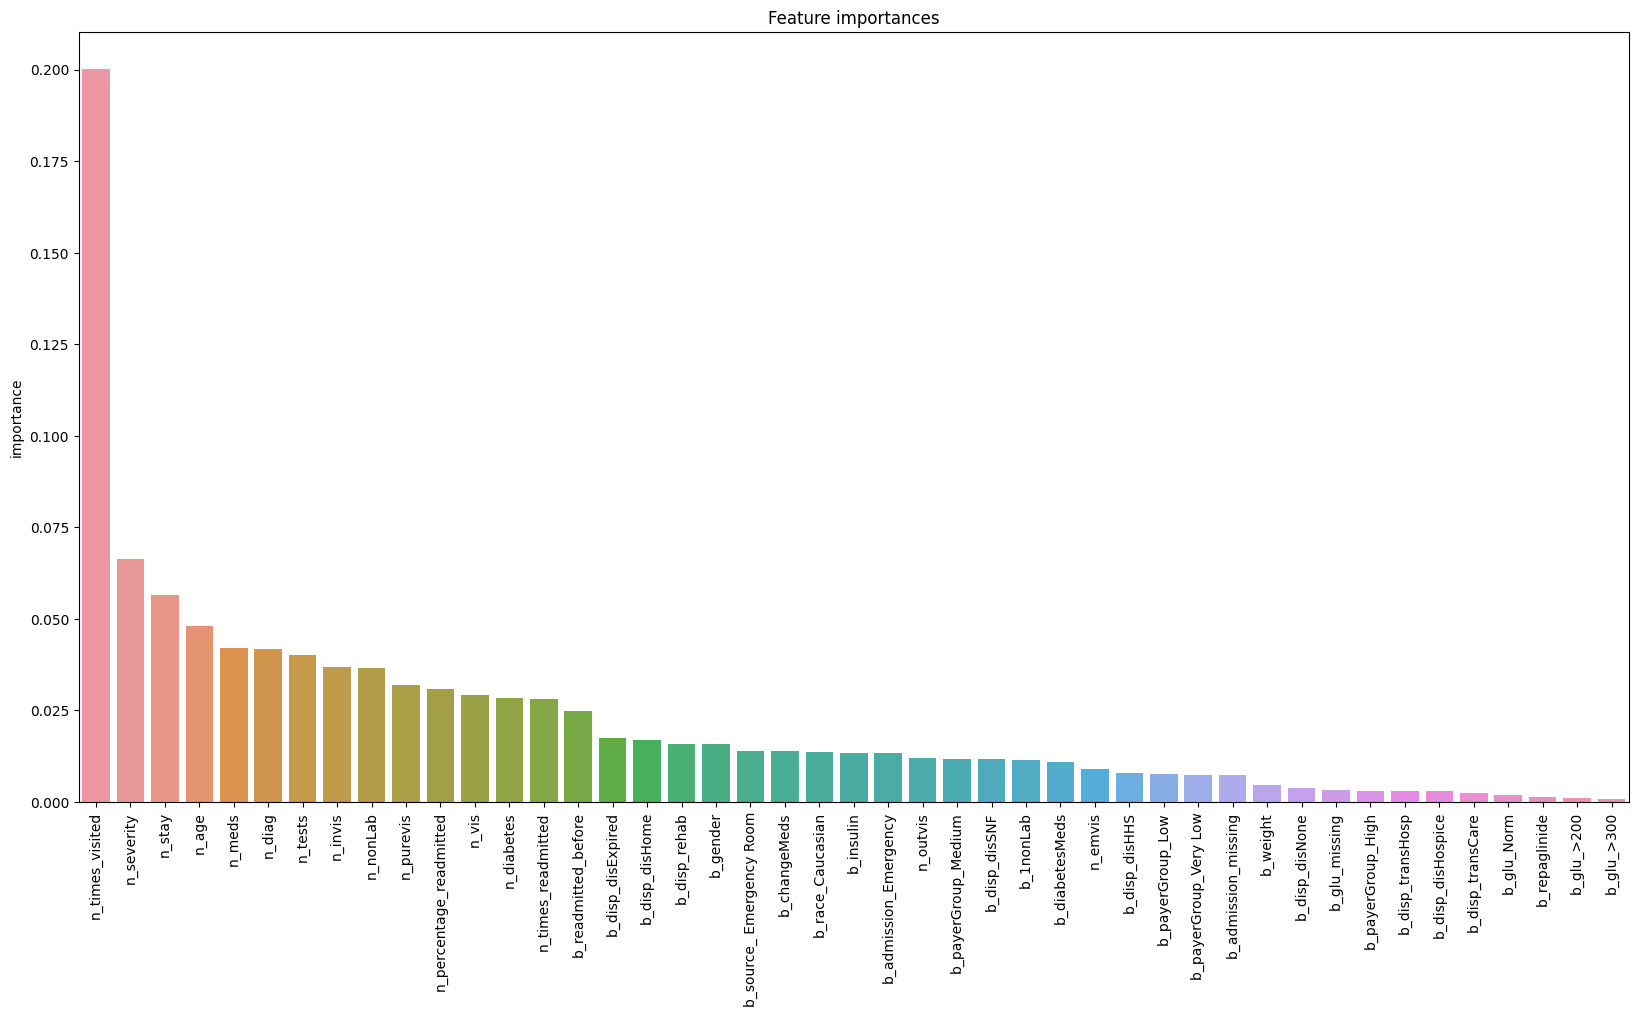

In [86]:
# Get the feature importances
feature_importances = pd.DataFrame(fit_rf.feature_importances_,
                                   index = train_light.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.title('Feature importances')
plt.show()

#### __XGBoost Classifier (0.364)__

##### Vanilla Model

In [98]:
# Using vanilla XGBoost
model = XGBClassifier()
test_model_cv(train_light, b_target, model, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True)

Starting fold 1/5...
Finished fold 1/5. Score train: 0.7927820129306186, score test: 0.34928804254589124
Starting fold 2/5...
Finished fold 2/5. Score train: 0.8029761962056386, score test: 0.34963366842733007
Starting fold 3/5...
Finished fold 3/5. Score train: 0.8009839386485313, score test: 0.33748082495312764
Starting fold 4/5...
Finished fold 4/5. Score train: 0.8014492053523984, score test: 0.34425377015080605
Starting fold 5/5...
Finished fold 5/5. Score train: 0.8001772947139196, score test: 0.34168564920273353
Average score: 0.3444683910559777 for params: None


0.3444683910559777

##### Parameter tunning

In [93]:
param_dict = {
    'n_estimators' : [val for val in range(50, 400,2)],
    'max_depth' : [val for val in range(2, 30)],
    'learning_rate' : [val for val in np.arange(0.01, 0.5, 0.01)],
    'gamma' : [val for val in np.arange(0, 1, 0.01)],
    'min_child_weight' : [val for val in range(1, 15)],
    'subsample' : [val for val in np.arange(0.5, 1, 0.01)],
    'colsample_bytree' : [val for val in np.arange(0.5, 1, 0.01)],
}

best_estimator = random_search_manual(train_light,b_target, model=XGBClassifier, params=param_dict, sampler='simple', scaler=MinMaxScaler(), iter=100, score_greedy=0.35, cv=5)

Doing 100 iterations with 5 folds, totally 500 fits...
Iteration 1/100...
{'n_estimators': 326, 'max_depth': 19, 'learning_rate': 0.08, 'gamma': 0.76, 'min_child_weight': 9, 'subsample': 0.9600000000000004, 'colsample_bytree': 0.6100000000000001}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.9783638583638583, score test: 0.3321637426900585. Stopping early...
Iteration 2/100...
{'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.13, 'gamma': 0.26, 'min_child_weight': 3, 'subsample': 0.7700000000000002, 'colsample_bytree': 0.9200000000000004}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.777843376247429, score test: 0.35641973324762977
Starting fold 2/5...
Finished fold 2/5. Score train: 0.7816868659067829, score test: 0.35382685069008785
Starting fold 3/5...
Finished fold 3/5. Score train: 0.784394250513347, score test: 0.3323185386957218
Starting fold 4/5...
Finished fold 4/5. Score train: 0.7815853368245654, score test: 0.3454574587405864
Starting fold 5/5...
Fin

- Some manual tweaking was done to the parameters, so that it could be possible to find a better model.
- Train_light seems to get worse results than the train full dataset, so it was decided to use the full dataset for the submission.

In [200]:
model = XGBClassifier(n_estimators=390, max_depth=16, learning_rate=0.0060, gamma=0.23, min_child_weight=5, subsample=0.60, colsample_bytree=0.51)
fit_xgb, scaler_xgb = test_model(model, train, b_target, test_size=0.3, sampler='simple', return_scaler=True, scaler=MinMaxScaler())

Accuracy:  0.8039775386055218
Precision:  0.28534031413612565
Recall:  0.5027253668763103
F1:  0.3640504023075755
Confusion matrix: 
 [[15982  3003]
 [ 1186  1199]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.84      0.88     18985
         1.0       0.29      0.50      0.36      2385

    accuracy                           0.80     21370
   macro avg       0.61      0.67      0.62     21370
weighted avg       0.86      0.80      0.83     21370



In [219]:
test = test[fit_xgb.get_booster().feature_names]
submit(test, fit_xgb, scaler_xgb)

#### __MPL Classifier (0.312)__

##### Vanilla Model

In [128]:
# Vanilla MLP
model = MLPClassifier()
test_model_cv(X_=train_light, y_=b_target, model=model, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True)

Starting fold 1/5...


C:\Users\mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished fold 1/5. Score train: 0.8171085202123842, score test: 0.30321543408360124
Starting fold 2/5...


C:\Users\mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished fold 2/5. Score train: 0.8004595105816177, score test: 0.30939849624060156
Starting fold 3/5...


C:\Users\mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished fold 3/5. Score train: 0.8029447657978549, score test: 0.3073618433899629
Starting fold 4/5...


C:\Users\mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished fold 4/5. Score train: 0.7977707642523271, score test: 0.31046931407942235
Starting fold 5/5...


C:\Users\mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished fold 5/5. Score train: 0.8151752290116949, score test: 0.3047760639286378
Average score: 0.3070442303444452 for params: None


0.3070442303444452

##### Model tunning

In [ ]:
param_dict = {
    'hidden_layer_sizes': [(5,5), (5,5,5), (10,10,10), (50,), (100,), (50, 50), (100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'batch_size': [200, 8, 16, 32, 64, 128, 256, 512],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'power_t': [0.5, 0.6, 0.7],
    'max_iter': [500],
    'verbose' : [True],
    'shuffle': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'warm_start': [False, True],
    'momentum': [0.9, 0.95, 0.99],
    'nesterovs_momentum': [True, False],
    'early_stopping': [False, True],
    'validation_fraction': [0.1, 0.2, 0.3],
    'beta_1': [0.9, 0.95, 0.99],
    'beta_2': [0.999, 0.995, 0.99],
    'epsilon': [1e-8, 1e-7, 1e-6],
    'n_iter_no_change': [5, 10, 15]
}

best_estimator = random_search_manual(train_light,b_target, model=MLPClassifier, params=param_dict, sampler='simple', scaler=MinMaxScaler(), iter=100, score_greedy=0.325, cv=4, n_jobs=None)

In [140]:
model = MLPClassifier(**{'hidden_layer_sizes': (10, 10, 10), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.01, 'batch_size': 128, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'power_t': 0.5, 'max_iter': 500, 'verbose': True, 'shuffle': True, 'tol': 0.0001, 'warm_start': True, 'momentum': 0.99, 'nesterovs_momentum': False, 'early_stopping': True, 'validation_fraction': 0.2, 'beta_1': 0.99, 'beta_2': 0.999, 'epsilon': 1e-07, 'n_iter_no_change': 15})
fit_mlp, scaler_mlp = test_model(model, train_light, b_target, test_size=0.3, sampler='simple', return_scaler=True, scaler=MinMaxScaler())

Iteration 1, loss = 0.69404812
Validation score: 0.500000
Iteration 2, loss = 0.69376231
Validation score: 0.500000
Iteration 3, loss = 0.69384362
Validation score: 0.500000
Iteration 4, loss = 0.69398913
Validation score: 0.500000
Iteration 5, loss = 0.69370709
Validation score: 0.500000
Iteration 6, loss = 0.69369930
Validation score: 0.500000
Iteration 7, loss = 0.69367334
Validation score: 0.500000
Iteration 8, loss = 0.69423833
Validation score: 0.500000
Iteration 9, loss = 0.69372782
Validation score: 0.500000
Iteration 10, loss = 0.69371523
Validation score: 0.500000
Iteration 11, loss = 0.69373056
Validation score: 0.500000
Iteration 12, loss = 0.69354475
Validation score: 0.500000
Iteration 13, loss = 0.69360359
Validation score: 0.500000
Iteration 14, loss = 0.69371184
Validation score: 0.500000
Iteration 15, loss = 0.69364525
Validation score: 0.502201
Iteration 16, loss = 0.69357392
Validation score: 0.500000
Iteration 17, loss = 0.69355079
Validation score: 0.500000
Iterat

In [141]:
submit(test, fit_mlp, scaler_mlp)

#### __ADA Boost__

##### Vanilla Model

In [170]:
# Using the vanilla ADABoost
model = AdaBoostClassifier()
test_model_cv(X_=train_light, y_=b_target, model=model, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True)

Starting fold 1/5...
Finished fold 1/5. Score train: 0.6955196349691761, score test: 0.3268517144129434
Starting fold 2/5...
Finished fold 2/5. Score train: 0.6963741399831626, score test: 0.328798510668767
Starting fold 3/5...
Finished fold 3/5. Score train: 0.6957182078392429, score test: 0.3211825487944891
Starting fold 4/5...
Finished fold 4/5. Score train: 0.6931285839245797, score test: 0.3247838616714698
Starting fold 5/5...
Finished fold 5/5. Score train: 0.6979379850947985, score test: 0.3232443715521098
Average score: 0.3249722014199558 for params: None


0.3249722014199558

##### Model tunning

### __KNN Classifier__

##### Vanilla Model

In [220]:
# KNN with vanilla parameters
model = KNeighborsClassifier()
test_model_cv(X_=train_light, y_=b_target, model=model, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True)

Starting fold 1/5...


AttributeError: 'Flags' object has no attribute 'c_contiguous'

##### Model tunning